In [40]:
# Imports

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import nltk

In [2]:
# Increase column width
pd.set_option('display.max_colwidth', 250)

## Preprocessing

### Load functions

In [3]:
%load_ext autoreload
%autoreload 2

import exam_functions as fn

### Load in the text classification dataframe from the provided file (part1-aml-belt-exam.csv)

In [4]:
df = pd.read_csv('Data/part1-aml-belt-exam.csv')
df.head()

,source,paragraph
0,Christie,"thought to be an Englishman, but they never got any clue as to his"
1,Christie,“Who?” The word came faintly between her parted lips.
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can"
3,Christie,The coincidence was rather startling. Could it be possible that
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves"


### Load the en_core_web_sm version of the spacy pipeline with the parser and ner disabled.

In [5]:
nlp_lite = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp_lite

### Preprocess with spacy

#### Create a column with Tokenized text (no stopwords)

In [7]:
%%time

df['tokens']= fn.batch_preprocess_texts(df['paragraph'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = False,)
                                        
   

27573it [00:34, 795.58it/s] 


CPU times: user 9.44 s, sys: 468 ms, total: 9.91 s
Wall time: 34.7 s


#### Create a column with Lemmatized text (no stopwords)

In [8]:
%%time
df['lemmas']= fn.batch_preprocess_texts(df['paragraph'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = True,)
                                        
   

27573it [00:33, 835.21it/s] 

CPU times: user 9.05 s, sys: 403 ms, total: 9.46 s
Wall time: 33 s


In [12]:
df.head()

,source,paragraph,tokens,lemmas,joined_tokens
0,Christie,"thought to be an Englishman, but they never got any clue as to his","[thought, englishman, got, clue]","[think, englishman, get, clue]",thought englishman got clue
1,Christie,“Who?” The word came faintly between her parted lips.,"[word, came, faintly, parted, lips]","[word, come, faintly, part, lip]",word came faintly parted lips
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can","[sound, likely, said, inspector]","[sound, likely, say, inspector]",sound likely said inspector
3,Christie,The coincidence was rather startling. Could it be possible that,"[coincidence, startling, possible]","[coincidence, startling, possible]",coincidence startling possible
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves","[thing, simple, pagett, person, loves]","[thing, simple, pagett, person, love]",thing simple pagett person loves


#### Create a column with the tokens for each text joined together as a single string.

In [9]:
df['joined_tokens'] = df['tokens'].map(lambda x: " ".join(x))

In [10]:
df['joined_tokens']

0                               thought englishman got clue
1                             word came faintly parted lips
2                               sound likely said inspector
3                            coincidence startling possible
4                          thing simple pagett person loves
                                ...                        
27568                      accentuated permission ask favor
27569                                   face unduly flushed
27570                              pulling impatiently bell
27571    yes answered laughing singular document philosophy
27572     mentioned earlier narrative like broad red church
Name: joined_tokens, Length: 27573, dtype: object

#### Create a column with the lemmas for each text joined together as a single string.

In [14]:
df['joined_lemmas'] = df['lemmas'].map(lambda x: " ".join(x))

In [15]:
df['joined_lemmas']

0                            think englishman get clue
1                           word come faintly part lip
2                           sound likely say inspector
3                       coincidence startling possible
4                      thing simple pagett person love
                             ...                      
27568                  accentuate permission ask favor
27569                              face unduly flushed
27570                            pull impatiently bell
27571    yes answer laugh singular document philosophy
27572    mention early narrative like broad red church
Name: joined_lemmas, Length: 27573, dtype: object

# Perform group comparison EDA:

## Define/separate two groups based on the source of the text (Conan Doyle or Christie)

In [17]:
df['source'].value_counts()

Conan Doyle    15016
Christie       12557
Name: source, dtype: int64

In [18]:
grp_ConanDoyle = df.loc[df['source'] == 'Conan Doyle']

In [20]:
grp_ConanDoyle

,source,paragraph,tokens,lemmas,joined_tokens,joined_lemmas
7,Conan Doyle,"block of a house, whitewashed, but all stained and streaked with damp","[block, house, whitewashed, stained, streaked, damp]","[block, house, whitewash, stain, streak, damp]",block house whitewashed stained streaked damp,block house whitewash stain streak damp
8,Conan Doyle,"glance showed me the unconscious Summerlee, most futile of sentinels,","[glance, showed, unconscious, summerlee, futile, sentinels]","[glance, show, unconscious, summerlee, futile, sentinel]",glance showed unconscious summerlee futile sentinels,glance show unconscious summerlee futile sentinel
12,Conan Doyle,me again with the same questioning and thoughtful look.,"[questioning, thoughtful, look]","[questioning, thoughtful, look]",questioning thoughtful look,questioning thoughtful look
13,Conan Doyle,Immediately beneath the cliff there grew a considerable patch of high,"[immediately, beneath, cliff, grew, considerable, patch, high]","[immediately, beneath, cliff, grow, considerable, patch, high]",immediately beneath cliff grew considerable patch high,immediately beneath cliff grow considerable patch high
15,Conan Doyle,"throwing-stick, or his arrow avail him against such forces as have been","[throwing, stick, arrow, avail, forces]","[throwing, stick, arrow, avail, force]",throwing stick arrow avail forces,throwing stick arrow avail force
...,...,...,...,...,...,...
27563,Conan Doyle,He picked it up and gazed at it in the peculiar introspective fashion,"[picked, gazed, peculiar, introspective, fashion]","[pick, gaze, peculiar, introspective, fashion]",picked gazed peculiar introspective fashion,pick gaze peculiar introspective fashion
27565,Conan Doyle,them to act as guides. After many adventures which I need not,"[act, guides, adventures, need]","[act, guide, adventure, need]",act guides adventures need,act guide adventure need
27568,Conan Doyle,"over-accentuated? With your permission, I would ask the favor of an","[accentuated, permission, ask, favor]","[accentuate, permission, ask, favor]",accentuated permission ask favor,accentuate permission ask favor
27571,Conan Doyle,"“Yes,” I answered, laughing. “It was a singular document. Philosophy,","[yes, answered, laughing, singular, document, philosophy]","[yes, answer, laugh, singular, document, philosophy]",yes answered laughing singular document philosophy,yes answer laugh singular document philosophy


In [19]:
grp_Christie = df.loc[df['source'] == 'Christie']

## Create word clouds for each group using raw text.

In [24]:
# get the text for group CananDoyle and display

grp_ConanDoyle_text = " ".join(grp_ConanDoyle['paragraph'])
print(grp_ConanDoyle_text[:500],"\n")

block of a house, whitewashed, but all stained and streaked with damp glance showed me the unconscious Summerlee, most futile of sentinels, me again with the same questioning and thoughtful look. Immediately beneath the cliff there grew a considerable patch of high throwing-stick, or his arrow avail him against such forces as have been every Saturday for the London Irish.  I'm not the man----" did to that of your friend. As to reward, my profession is its own thinking that Blundell got him at th 



In [25]:
# get the text for group Christie and display

grp_Christie_text = " ".join(grp_Christie['paragraph'])
print(grp_Christie_text[:500],"\n")

thought to be an Englishman, but they never got any clue as to his “Who?” The word came faintly between her parted lips. “Doesn’t sound likely to me,” said the inspector. “But—well, can The coincidence was rather startling. Could it be possible that The thing seemed simple enough, but Pagett is a person who loves We thanked our informant, and drove on, leaving the town behind. A fork Lord Nasby stretched out a careless hand. “What was he like?” Then I started to jump to conclusions. Not knowing  



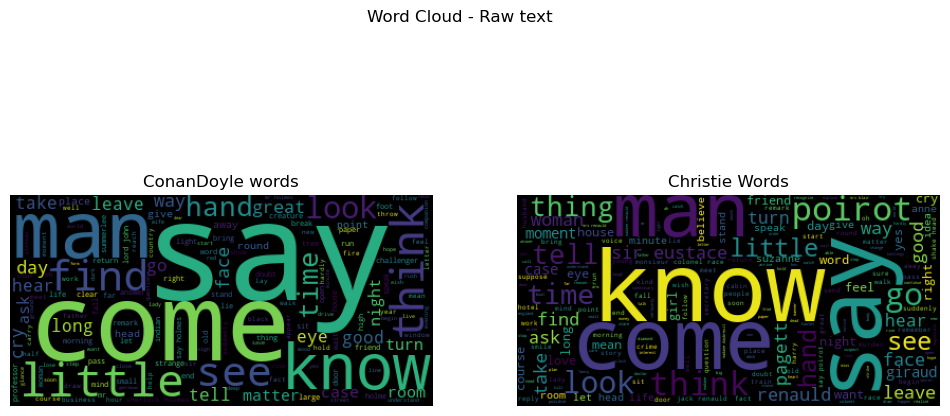

In [34]:
# Create a word clouds of above texts

from wordcloud import WordCloud, STOPWORDS
ConanDoyle_cloud = WordCloud(min_word_length=2).generate(grp_ConanDoyle_text)
Christie_cloud = WordCloud(min_word_length=2).generate(grp_Christie_text)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(ConanDoyle_cloud)
axes[0].set_title('ConanDoyle words')
axes[0].axis('off')

axes[1].imshow(Christie_cloud)
axes[1].set_title('Christie Words')
axes[1].axis('off');
fig.suptitle('Word Cloud - Raw text');

## Create word clouds for each group using lemmatized text.

In [29]:
# get the text for group CananDoyle and display

grp_ConanDoyle_text = " ".join(grp_ConanDoyle['joined_lemmas'])
print(grp_ConanDoyle_text[:500],"\n")

# get the text for group Christie and display

grp_Christie_text = " ".join(grp_Christie['joined_lemmas'])
print(grp_Christie_text[:500],"\n")

block house whitewash stain streak damp glance show unconscious summerlee futile sentinel questioning thoughtful look immediately beneath cliff grow considerable patch high throwing stick arrow avail force saturday london irish man---- friend reward profession think blundell get wrong moment maybe time go door knock instantly far river good day miss hunter strike gong table attempt establish practice london take live slop shop gin shop approach steep flight abroad fail health time business water 

think englishman get clue word come faintly part lip sound likely say inspector coincidence startling possible thing simple pagett person love thank informant drive leave town fork lord nasby stretch careless hand like start jump conclusion know sir eustace enter give nod dismissal go leave huddle garment step cool night know nearly o’clock hate uncomfortable address take time irregular secret passage room find find possible witness think know right know world obvious m. renauld write letter 

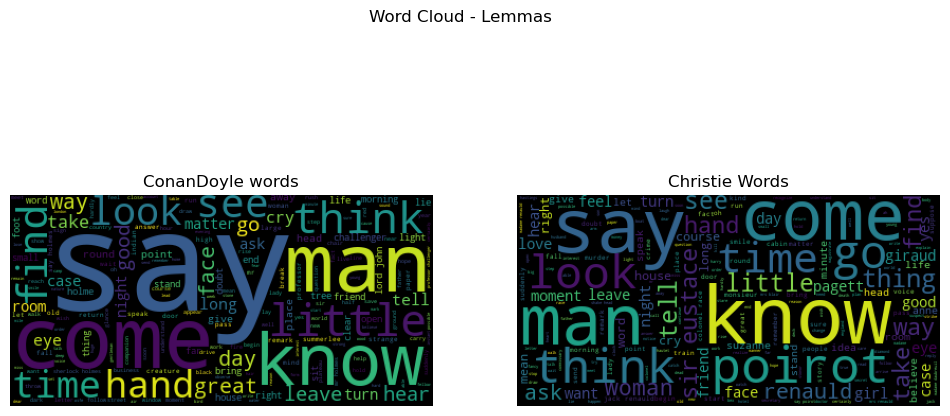

In [33]:
# Create a word clouds of above texts

from wordcloud import WordCloud, STOPWORDS
ConanDoyle_cloud = WordCloud(min_word_length=2).generate(grp_ConanDoyle_text)
Christie_cloud = WordCloud(min_word_length=2).generate(grp_Christie_text)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(ConanDoyle_cloud)
axes[0].set_title('ConanDoyle words')
axes[0].axis('off')

axes[1].imshow(Christie_cloud)
axes[1].set_title('Christie Words')
axes[1].axis('off')
fig.suptitle('Word Cloud - Lemmas');

## Display the top 20 most frequent bigrams for both groups in a single dataframe
- Tip/Note: When making the exploded list of tokens, you must include .astype(str) to ensure all tokens are strings. If you do not, you will get an error message! You can chain the methods together as follows:  .explode().astype(str).to_list()

In [36]:
grp_ConanDoyle_tokens = grp_ConanDoyle['tokens'].explode().astype(str).to_list()

In [37]:
grp_Christie_tokens = grp_Christie['tokens'].explode().astype(str).to_list()

In [38]:
grp_ConanDoyle_tokens

['block',
 'house',
 'whitewashed',
 'stained',
 'streaked',
 'damp',
 'glance',
 'showed',
 'unconscious',
 'summerlee',
 'futile',
 'sentinels',
 'questioning',
 'thoughtful',
 'look',
 'immediately',
 'beneath',
 'cliff',
 'grew',
 'considerable',
 'patch',
 'high',
 'throwing',
 'stick',
 'arrow',
 'avail',
 'forces',
 'saturday',
 'london',
 'irish',
 'man----',
 'friend',
 'reward',
 'profession',
 'thinking',
 'blundell',
 'got',
 'wrong',
 'moment',
 'maybe',
 'times',
 'went',
 'door',
 'knocked',
 'instantly',
 'far',
 'river',
 'good',
 'day',
 'miss',
 'hunter',
 'struck',
 'gong',
 'table',
 'attempts',
 'establish',
 'practice',
 'london',
 'took',
 'live',
 'slop',
 'shop',
 'gin',
 'shop',
 'approached',
 'steep',
 'flight',
 'abroad',
 'failing',
 'health',
 'time',
 'business',
 'water',
 'carafe',
 'table',
 'humorous',
 'twinkling',
 'aside',
 'let',
 'wailed',
 'answered',
 'utmost',
 'coolness',
 'fancy',
 'hinted',
 'trouble',
 'professor',
 'baggage',
 'gave',
 

In [39]:
grp_Christie_tokens

['thought',
 'englishman',
 'got',
 'clue',
 'word',
 'came',
 'faintly',
 'parted',
 'lips',
 'sound',
 'likely',
 'said',
 'inspector',
 'coincidence',
 'startling',
 'possible',
 'thing',
 'simple',
 'pagett',
 'person',
 'loves',
 'thanked',
 'informant',
 'drove',
 'leaving',
 'town',
 'fork',
 'lord',
 'nasby',
 'stretched',
 'careless',
 'hand',
 'like',
 'started',
 'jump',
 'conclusions',
 'knowing',
 'sir',
 'eustace',
 'entered',
 'gave',
 'nod',
 'dismissal',
 'went',
 'leaving',
 'huddled',
 'garments',
 'stepped',
 'cool',
 'night',
 'know',
 'nearly',
 'o’clock',
 'hates',
 'uncomfortable',
 'address',
 'taken',
 'time',
 'irregular',
 'secret',
 'passage',
 'room',
 'found',
 'find',
 'possible',
 'witness',
 'think',
 'know',
 'right',
 'know',
 'world',
 'obvious',
 'm.',
 'renauld',
 'wrote',
 'letter',
 'blotting',
 'reread',
 'chapter',
 'viii',
 'gives',
 'write',
 'enormous',
 'pleasure',
 'know',
 'monsieur',
 'wish',
 'occasion',
 'distress',
 'supporting',
 'a

In [41]:
# using custom function get_ngram_measures_finder to get the bigrams

bigram_grp_ConanDoyle = fn.get_ngram_measures_finder(grp_ConanDoyle_tokens,top_n=20)

bigram_grp_Christie = fn.get_ngram_measures_finder(grp_Christie_tokens,top_n=20)

In [42]:
bigram_grp_ConanDoyle,bigram_grp_Christie

(                      Words  Raw Freq
 0              (lord, john)  0.001841
 1            (said, holmes)  0.001525
 2        (sherlock, holmes)  0.001280
 3             (mr., holmes)  0.000978
 4   (professor, challenger)  0.000920
 5                (said, i.)  0.000547
 6                (ape, men)  0.000532
 7              (st., simon)  0.000503
 8    (professor, summerlee)  0.000431
 9              (said, lord)  0.000417
 10              (lord, st.)  0.000403
 11           (john, roxton)  0.000374
 12          (baker, street)  0.000360
 13             (st., clair)  0.000345
 14           (maple, white)  0.000331
 15          (young, fellah)  0.000331
 16            (red, headed)  0.000316
 17       (said, challenger)  0.000316
 18            (young, lady)  0.000302
 19             (young, man)  0.000288,
                       Words  Raw Freq
 0            (sir, eustace)  0.003736
 1             (m., renauld)  0.001923
 2           (jack, renauld)  0.001777
 3           (colonel, r